### Install packages

In [1]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("dada2")
BiocManager::install("ShortRead")
install.packages("magrittr")
install.packages("stringr")
install.packages("data.table")
install.packages("qualpalr")
install.packages("seqinr")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.14 (BiocManager 1.30.16), R 4.1.3 (2022-03-10)

Warning message:
“package(s) not installed when version(s) same as current; use `force = TRUE` to
  re-install: 'dada2'”
Old packages: 'ade4', 'BH', 'BiocManager', 'broom', 'colorspace', 'cpp11',
  'crayon', 'digest', 'dplyr', 'evaluate', 'fansi', 'farver', 'formatR',
  'generics', 'ggplot2', 'gtable', 'htmltools', 'hwriter', 'IRkernel',
  'isoband', 'jpeg', 'jsonlite', 'latticeExtra', 'MASS', 'Matrix',
  'matrixStats', 'mgcv', 'nlme', 'pbdZMQ', 'pillar', 'plyr', 'png', 'purrr',
  'randtoolbox', 'Rcpp', 'RcppArmadillo', 'RcppParallel', 'RCurl', 'repr',
  'rngWELL', 'scales', 'segmented', 'sp', 'stringi', 'tibble', 'tidyr',
  'tidyselect', 'utf8', 'uuid', 'vctrs', 'viridisLite'

'getOption("repos")' replaces Bioconductor standard repositories, see
'?reposi

### Load libraries

In [2]:
library(dada2)
library(stringr)
library(data.table)
library(qualpalr)
library(ShortRead)
library(Biostrings)
library(seqinr)

Loading required package: Rcpp

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: BiocParallel

Loading required package: Biostrings

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:data.table’:

    first, second


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading

### File path setup

In [3]:
rawpath <- "raw"
wdpath <- "/home/allie/domhain/2023-Longitudinal_oral_microbiome/01-read_processing" # change to where git repository was cloned
fnFs <- sort(list.files(rawpath, pattern="_R1_001.fastq.gz", full.names=T))
fnRs <- sort(list.files(rawpath, pattern="_R2_001.fastq.gz", full.names=T))
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)
head(sample.names, 10)
paste("Number of input samples: ", length(sample.names))

[1] "2L13-PD1" "2L13-PE1" "2L13-PF1" "2L17-PE1" "2L17-PF1" "2L2-PD1" 
 [7] "2L2-PE1"  "2L2-PF1"  "2L23-PD1" "2L23-PE1"

[1] "Number of input samples:  2436"

### Plot quality scores

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


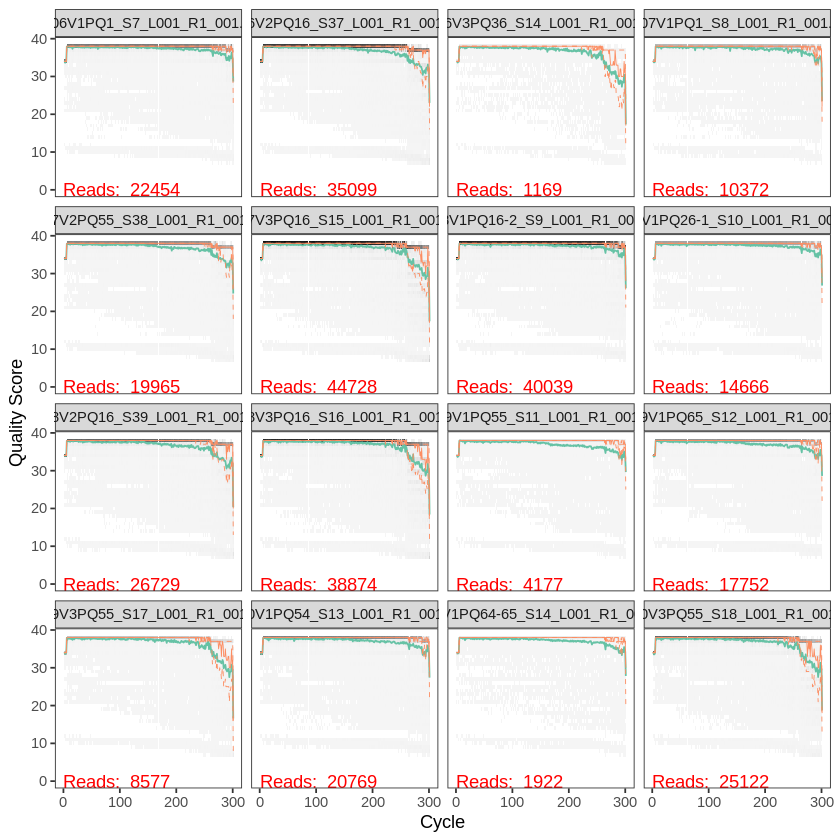

png 
  2

png 
  2

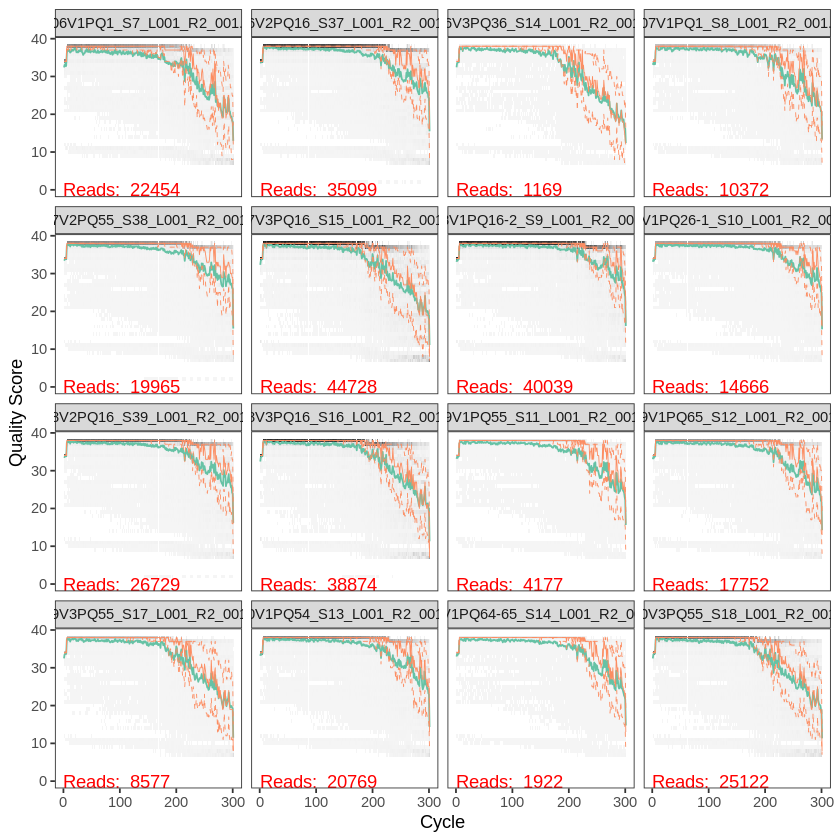

In [4]:
system("mkdir img") # ignore warning
fwdqual <- plotQualityProfile(fnFs[100:115])
revqual <- plotQualityProfile(fnRs[100:115])
fwdqual
revqual

pdf(paste(wdpath, "/img/", "forward_quality_plot.pdf", sep=""))
fwdqual
dev.off()
pdf(paste(wdpath, "/img/", "reverse_quality_plot.pdf", sep=""))
revqual
dev.off()

### Preliminary filter (remove sequences with uncalled bases)

In [5]:
fnFs.filtN <- file.path(rawpath, "filtN", basename(fnFs)) # Put N-filtered files in filtN/ subdirectory
fnRs.filtN <- file.path(rawpath, "filtN", basename(fnRs))
filterAndTrim(fnFs, fnFs.filtN, fnRs, fnRs.filtN, maxN = 0, multithread = TRUE, compress = TRUE, matchIDs=TRUE)

### Primer trimming

In [6]:
cutadapt <- as.character(system("which cutadapt", intern=T))
system("cutadapt --version")
path.cut <- file.path(rawpath, "cutadapt")
if(!dir.exists(path.cut)) dir.create(path.cut)
fnFs.cut <- file.path(path.cut, basename(fnFs))
fnRs.cut <- file.path(path.cut, basename(fnRs))
FWD.RC <- dada2:::rc("MAYGARAARMGNATGYTNCARGA")
REV.RC <- dada2:::rc("GMCATYTGRTCNCCRTCRAA")
# Trim FWD and the reverse-complement of REV off of R1 (forward reads)
R1.flags <- paste("-g", "MAYGARAARMGNATGYTNCARGA", "-a", REV.RC) 
# Trim REV and the reverse-complement of FWD off of R2 (reverse reads)
R2.flags <- paste("-G", "GMCATYTGRTCNCCRTCRAA", "-A", FWD.RC) 
for(i in seq_along(fnFs)) {
  system2(cutadapt, args = c("--cores=0", R1.flags, R2.flags, "-n", 2,"-o", fnFs.cut[i], "-p", fnRs.cut[i], fnFs.filtN[i], fnRs.filtN[i]))
}
cutFs <- sort(list.files(path.cut, pattern = "R1", full.names = TRUE))
cutRs <- sort(list.files(path.cut, pattern = "R2", full.names = TRUE))

### Quality filter and trim reads

In [7]:
filtFs <- file.path(path.cut, "filtered", basename(cutFs))
filtRs <- file.path(path.cut, "filtered", basename(cutRs))
out <- filterAndTrim(cutFs, filtFs, cutRs, filtRs, trimRight=25, maxN=c(0,0), maxEE=c(4,6), rm.phix=TRUE, matchIDs=TRUE, compress=TRUE, multithread=TRUE)
retained <- as.data.frame(out)
# aiming for around 80% or more retention
retained$prop.postqual <- retained$reads.out/retained$reads.in*100
head(retained)
mean(retained$prop.postqual)
median(retained$prop.postqual)

,reads.in,reads.out,prop.postqual
,<dbl>,<dbl>,<dbl>
2L13-PD1_S1_L001_R1_001.fastq.gz,53293,43742,82.07832
2L13-PE1_S7_L001_R1_001.fastq.gz,51802,41455,80.02587
2L13-PF1_S13_L001_R1_001.fastq.gz,50704,44991,88.73264
2L17-PE1_S19_L001_R1_001.fastq.gz,56847,50544,88.91234
2L17-PF1_S25_L001_R1_001.fastq.gz,56009,49541,88.45186
2L2-PD1_S4_L001_R1_001.fastq.gz,50309,40624,80.74897


[1] 89.32866

[1] 92.48444

### Learn and plot error rates

102887415 total bases in 416132 reads from 14 samples will be used for learning the error rates.
110073109 total bases in 445968 reads from 11 samples will be used for learning the error rates.


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


png 
  2

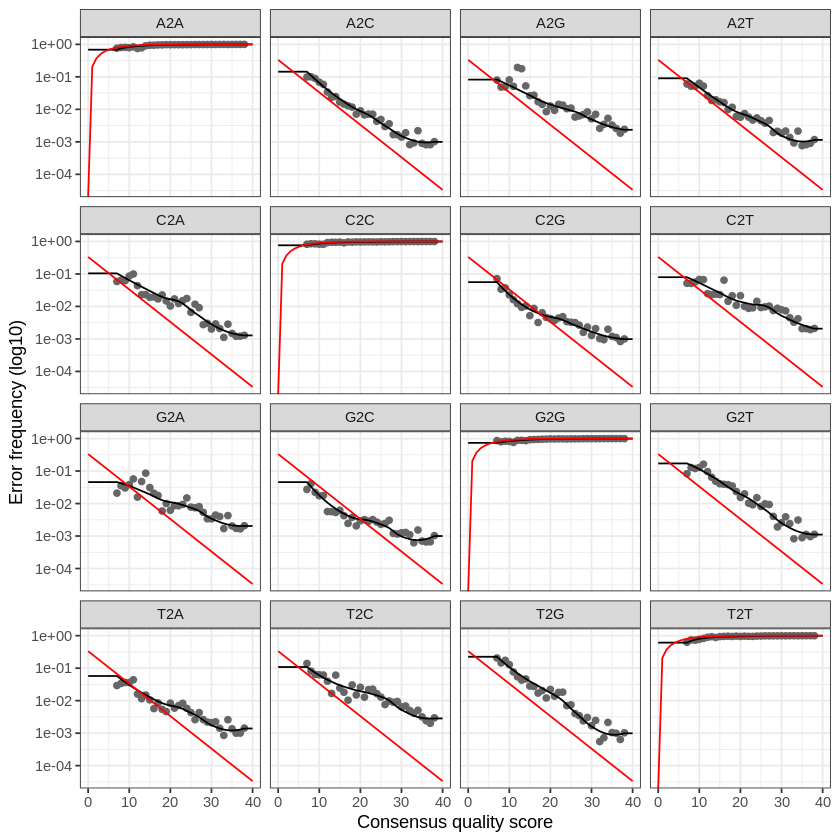

In [8]:
set.seed(12349)
errF <- learnErrors(filtFs, multithread=T, random=T)
errR <- learnErrors(filtRs, multithread=T, random=T)
err.f.plt <- plotErrors(errF, nominalQ=TRUE) 
err.f.plt
pdf(paste(wdpath, "/img/", "error_plot.pdf", sep=""))
err.f.plt
dev.off()

### Dereplication

In [9]:
derepFs <- derepFastq(filtFs, verbose=FALSE)
derepRs <- derepFastq(filtRs, verbose=FALSE)
# reassign sample names
sample.names <- sapply(strsplit(basename(filtFs), "_"), `[`, 1)
names(derepFs) <- sample.names
names(derepRs) <- sample.names

### Sample inference

In [10]:
dadaFs <- dada(derepFs, err=errF, multithread=TRUE, verbose=FALSE)
dadaRs <- dada(derepRs, err=errR, multithread=TRUE, verbose=FALSE)

Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”


### Merge paired-end reads

In [11]:
mergers <- mergePairs(dadaFs, derepFs, dadaRs, derepRs, verbose=FALSE)

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.



### Construct sequence table

In [12]:
seqtab <- makeSequenceTable(mergers)
dim(seqtab)

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.



[1]   2436 140483

### Length filter

In [13]:
# sequence length table
table(nchar(colnames(seqtab)))


   33    56    62    63    64    65    66    67    68    69    70    71    72 
    1     1    76   139   136    36    85   140    96    86   165    55   150 
   73    74    75    76    77    78    79    80    81    82    83    84    85 
  102    84   108   140    93   181   112    99    66   158    62   144   221 
   86    87    88    89    90    91    92    93    94    95    96    97    98 
  107   126   182   139   128   225    85   166   200    80   196   119   300 
   99   100   101   102   103   104   105   106   107   108   109   110   111 
  133   121    94   131   198    93   166   123   105   159   126    92   130 
  112   113   114   115   116   117   118   119   120   121   122   123   124 
  191   101   194   182   117   137   188    86    70   111    98   201   278 
  125   126   127   128   129   130   131   132   133   134   135   136   137 
  142    93   309   167   152   180    75   113   129    99    70   164   205 
  138   139   140   141   142   143   144   145   1

Filter out any ASVs shorter than 450 bp in length

In [14]:
seqlens <- nchar(getSequences(seqtab))
seqtab.filt <- seqtab[,seqlens > 450]
dim(seqtab.filt)

[1]   2436 103563

Sequence length distribution after filter

png 
  2

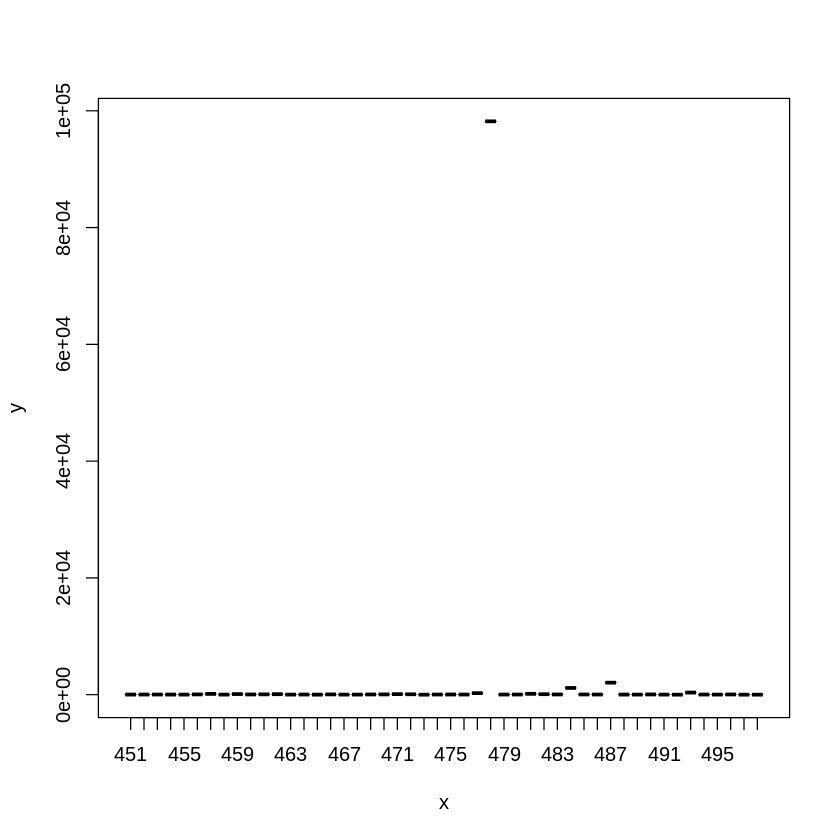

In [15]:
length.histogram <- as.data.frame(table(nchar(getSequences(seqtab.filt))))
plot(x=length.histogram[,1], y=length.histogram[,2])
pdf(paste(wdpath, "/img/", "length_hist.pdf", sep=""))
plot(x=length.histogram[,1], y=length.histogram[,2])
dev.off()

### Chimera detection and removal

In [16]:
seqtab.nochim <- removeBimeraDenovo(seqtab.filt, method="pooled", multithread=T, verbose=T)
dim(seqtab.nochim)
sum(seqtab.nochim)/sum(seqtab.filt)

Identified 61991 bimeras out of 103563 input sequences.



[1]  2436 41572

[1] 0.9119396

### Processing summary

In [17]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim))
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nochimeras")
rownames(track) <- sample.names
track

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.



,input,filtered,denoisedF,denoisedR,merged,nochimeras
2L13-PD1,53293,43742,43171,41854,39907,32368
2L13-PE1,51802,41455,40743,40008,37621,28797
2L13-PF1,50704,44991,44279,43685,40593,34708
2L17-PE1,56847,50544,49918,49198,45583,40505
2L17-PF1,56009,49541,48702,48498,44673,39180
2L2-PD1,50309,40624,40142,40309,31465,30257
2L2-PE1,62524,54860,53923,53025,49805,46457
2L2-PF1,53183,48581,47954,47785,45981,43843
2L23-PD1,40489,33113,32656,32158,31187,27437
2L23-PE1,60126,48884,47963,46454,43742,40255


### Save output

In [18]:
write.table(data.frame("row_names"=rownames(track),track),"read_retention.txt", row.names=FALSE, quote=F, sep="\t")
uniquesToFasta(seqtab.nochim, "rep_set.fa")
system("awk '/^>/{print \">ASV\" ++i; next}{print}' < rep_set.fa > rep_set_fix.fa")
system("mv rep_set_fix.fa rep_set.fa")

### Clean up ASV names

In [19]:
my_otu_table <- t(as.data.frame(seqtab.nochim)) 
ASV.seq <- as.character(unclass(row.names(my_otu_table))) 
ASV.num <- paste0("ASV", seq(ASV.seq), sep='') 
colnames(seqtab.nochim) <- ASV.num 
write.table(data.frame("row_names"=rownames(seqtab.nochim),seqtab.nochim),"sequence_table.merged.txt", row.names=FALSE, quote=F, sep="\t")